In [2]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
import random
import shutil             # to copy images to another directory 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
plt.style.use('ggplot')

print("Lib Done")

Lib Done


In [3]:
dataDirList = ['/kaggle/input/garbage-classification/Garbage classification/Garbage classification/' , 
              '/kaggle/input/d/mostafaabla/garbage-classification/garbage_classification/']

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']

In [4]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)
            
# Convert the 2 lists to dataframe to easy use 
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

imgPath      label
0     /kaggle/input/d/mostafaabla/garbage-classifica...      paper
1     /kaggle/input/garbage-classification/Garbage c...    plastic
2     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
3     /kaggle/input/d/mostafaabla/garbage-classifica...    plastic
4     /kaggle/input/d/mostafaabla/garbage-classifica...      glass
...                                                 ...        ...
7569  /kaggle/input/d/mostafaabla/garbage-classifica...      metal
7570  /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
7571  /kaggle/input/d/mostafaabla/garbage-classifica...      paper
7572  /kaggle/input/d/mostafaabla/garbage-classifica...    plastic
7573  /kaggle/input/d/mostafaabla/garbage-classifica...      glass

[7574 rows x 2 columns]

In [7]:
# get the ratio such as 15% of each class for testing 
def DataFrameSpliting(df , ratio , classesList):
    
    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)
        
    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [9]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

In [10]:
# Another way for spliting a dataframe 

# def splitingData(dataFrame , ratio):
#     lastIndex = int(len(dataFrame) * ratio)
#     trainDf = dataFrame[:lastIndex]
#     testDf = dataFrame[lastIndex:]
#     return trainDf , testDf

In [11]:
trainDf

imgPath      label
0     /kaggle/input/garbage-classification/Garbage c...  cardboard
1     /kaggle/input/garbage-classification/Garbage c...    plastic
2     /kaggle/input/garbage-classification/Garbage c...      paper
3     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
4     /kaggle/input/d/mostafaabla/garbage-classifica...      paper
...                                                 ...        ...
6429  /kaggle/input/d/mostafaabla/garbage-classifica...      paper
6430  /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
6431  /kaggle/input/d/mostafaabla/garbage-classifica...      paper
6432  /kaggle/input/d/mostafaabla/garbage-classifica...      glass
6433  /kaggle/input/d/mostafaabla/garbage-classifica...      paper

[6434 rows x 2 columns]

In [12]:
trainDf['label'].value_counts()

label
paper        1397
plastic      1144
cardboard    1099
glass        1084
metal        1002
trash         708
Name: count, dtype: int64

In [14]:
testDf

imgPath      label
0     /kaggle/input/garbage-classification/Garbage c...      trash
1     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
2     /kaggle/input/d/mostafaabla/garbage-classifica...      metal
3     /kaggle/input/garbage-classification/Garbage c...    plastic
4     /kaggle/input/d/mostafaabla/garbage-classifica...      glass
...                                                 ...        ...
1135  /kaggle/input/garbage-classification/Garbage c...      glass
1136  /kaggle/input/garbage-classification/Garbage c...    plastic
1137  /kaggle/input/d/mostafaabla/garbage-classifica...    plastic
1138  /kaggle/input/d/mostafaabla/garbage-classifica...      trash
1139  /kaggle/input/d/mostafaabla/garbage-classifica...      paper

[1140 rows x 2 columns]

In [16]:
testDf['label'].value_counts()

label
paper        247
plastic      203
cardboard    195
glass        192
metal        177
trash        126
Name: count, dtype: int64

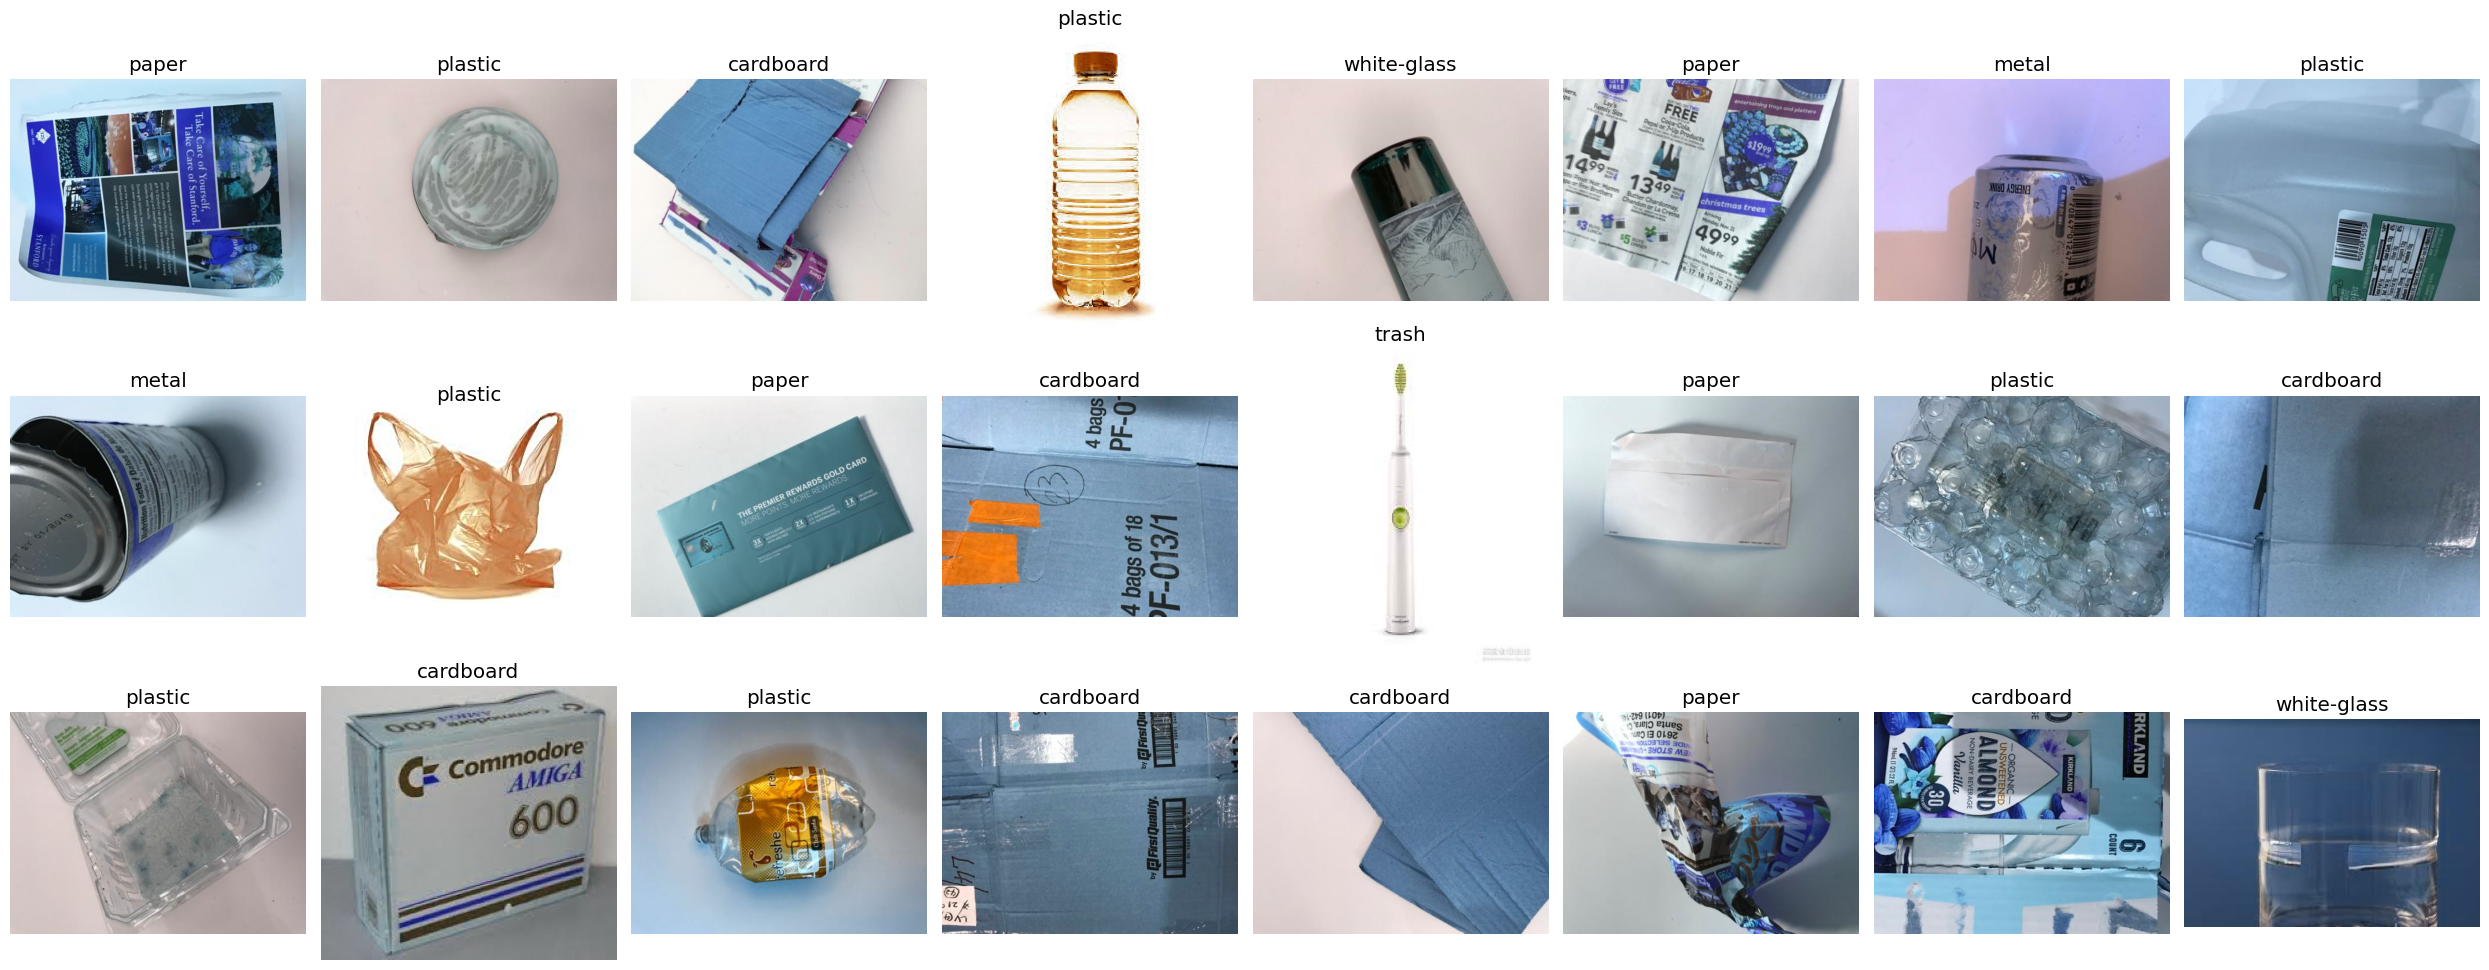

In [17]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path 
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [19]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in 
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [20]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once 
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6434 validated image filenames belonging to 6 classes.
Found 1140 validated image filenames belonging to 6 classes.
Training set size: 6434
Testing set size: 1140


In [21]:
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([
        
#         Resizing(IMG_SIZE),
        
#         Rescaling(1./255),     These two steps ,we did perform them above with test and image generator 
    
        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
        
        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False 
        
        Dense(64,activation='relu'),
        
        BatchNormalization(),
        
        Dropout(0.08),

        Dense(6 ,activation='softmax')
    ])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [26]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [27]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator, 
                    epochs=50,
#                     batch_size=64,   # we define it above inside trainGenerator
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1765435727.423898     113 service.cc:145] XLA service 0x7ced78005f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765435727.423971     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/101 ━━━━━━━━━━━━━━━━━━━━ 36:53 22s/step - accuracy: 0.1250 - loss: 2.5727

I0000 00:00:1765435735.118589     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6951 - loss: 0.8687 - val_accuracy: 0.8368 - val_loss: 0.4892
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 709ms/step - accuracy: 0.8621 - loss: 0.3859 - val_accuracy: 0.8623 - val_loss: 0.3877
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 75s 697ms/step - accuracy: 0.9021 - loss: 0.2700 - val_accuracy: 0.8561 - val_loss: 0.3947
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 706ms/step - accuracy: 0.9278 - loss: 0.2128 - val_accuracy: 0.8947 - val_loss: 0.3100
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 706ms/step - accuracy: 0.9414 - loss: 0.1659 - val_accuracy: 0.8956 - val_loss: 0.3227
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 701ms/step - accuracy: 0.9472 - loss: 0.1563 - val_accuracy: 0.9088 - val_loss: 0.2895
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 699ms/step - accuracy: 0.9594 - loss: 0.1240 - val_accuracy: 0.9105 - val_loss: 0.2687
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 703ms/step - accuracy: 0.9595 - loss: 0.1122 - val_a

In [28]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,127,700 (57.71 MB)

 Trainable params: 4,427,462 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,854,926 (33.78 MB)

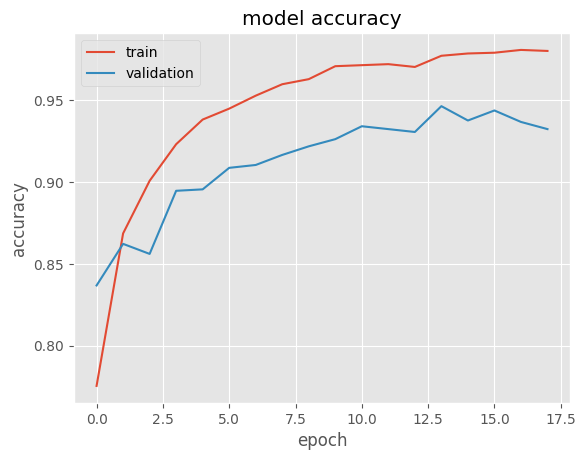

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
predictions = Model.predict(testGenerator)

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


In [31]:
trainGenerator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [32]:
trueClasses = testGenerator.classes
trueClasses[:10]

[5, 0, 2, 4, 1, 2, 1, 1, 5, 2]

In [33]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([5, 0, 2, 4, 1, 2, 1, 2, 5, 2])

In [34]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9462 - loss: 0.1923


0.9464912414550781

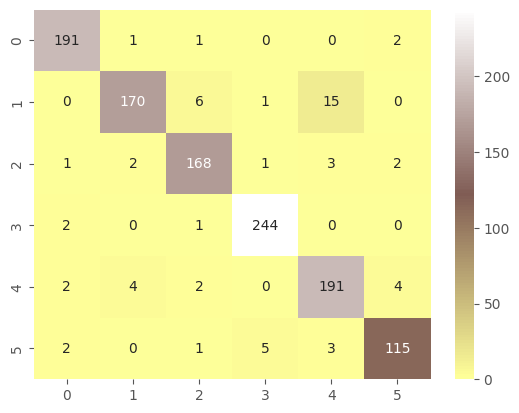

In [35]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [36]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       195
           1       0.96      0.89      0.92       192
           2       0.94      0.95      0.94       177
           3       0.97      0.99      0.98       247
           4       0.90      0.94      0.92       203
           5       0.93      0.91      0.92       126

    accuracy                           0.95      1140
   macro avg       0.95      0.94      0.94      1140
weighted avg       0.95      0.95      0.95      1140



In [37]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index
    
    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index
    
    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]
    
    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)
    
    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


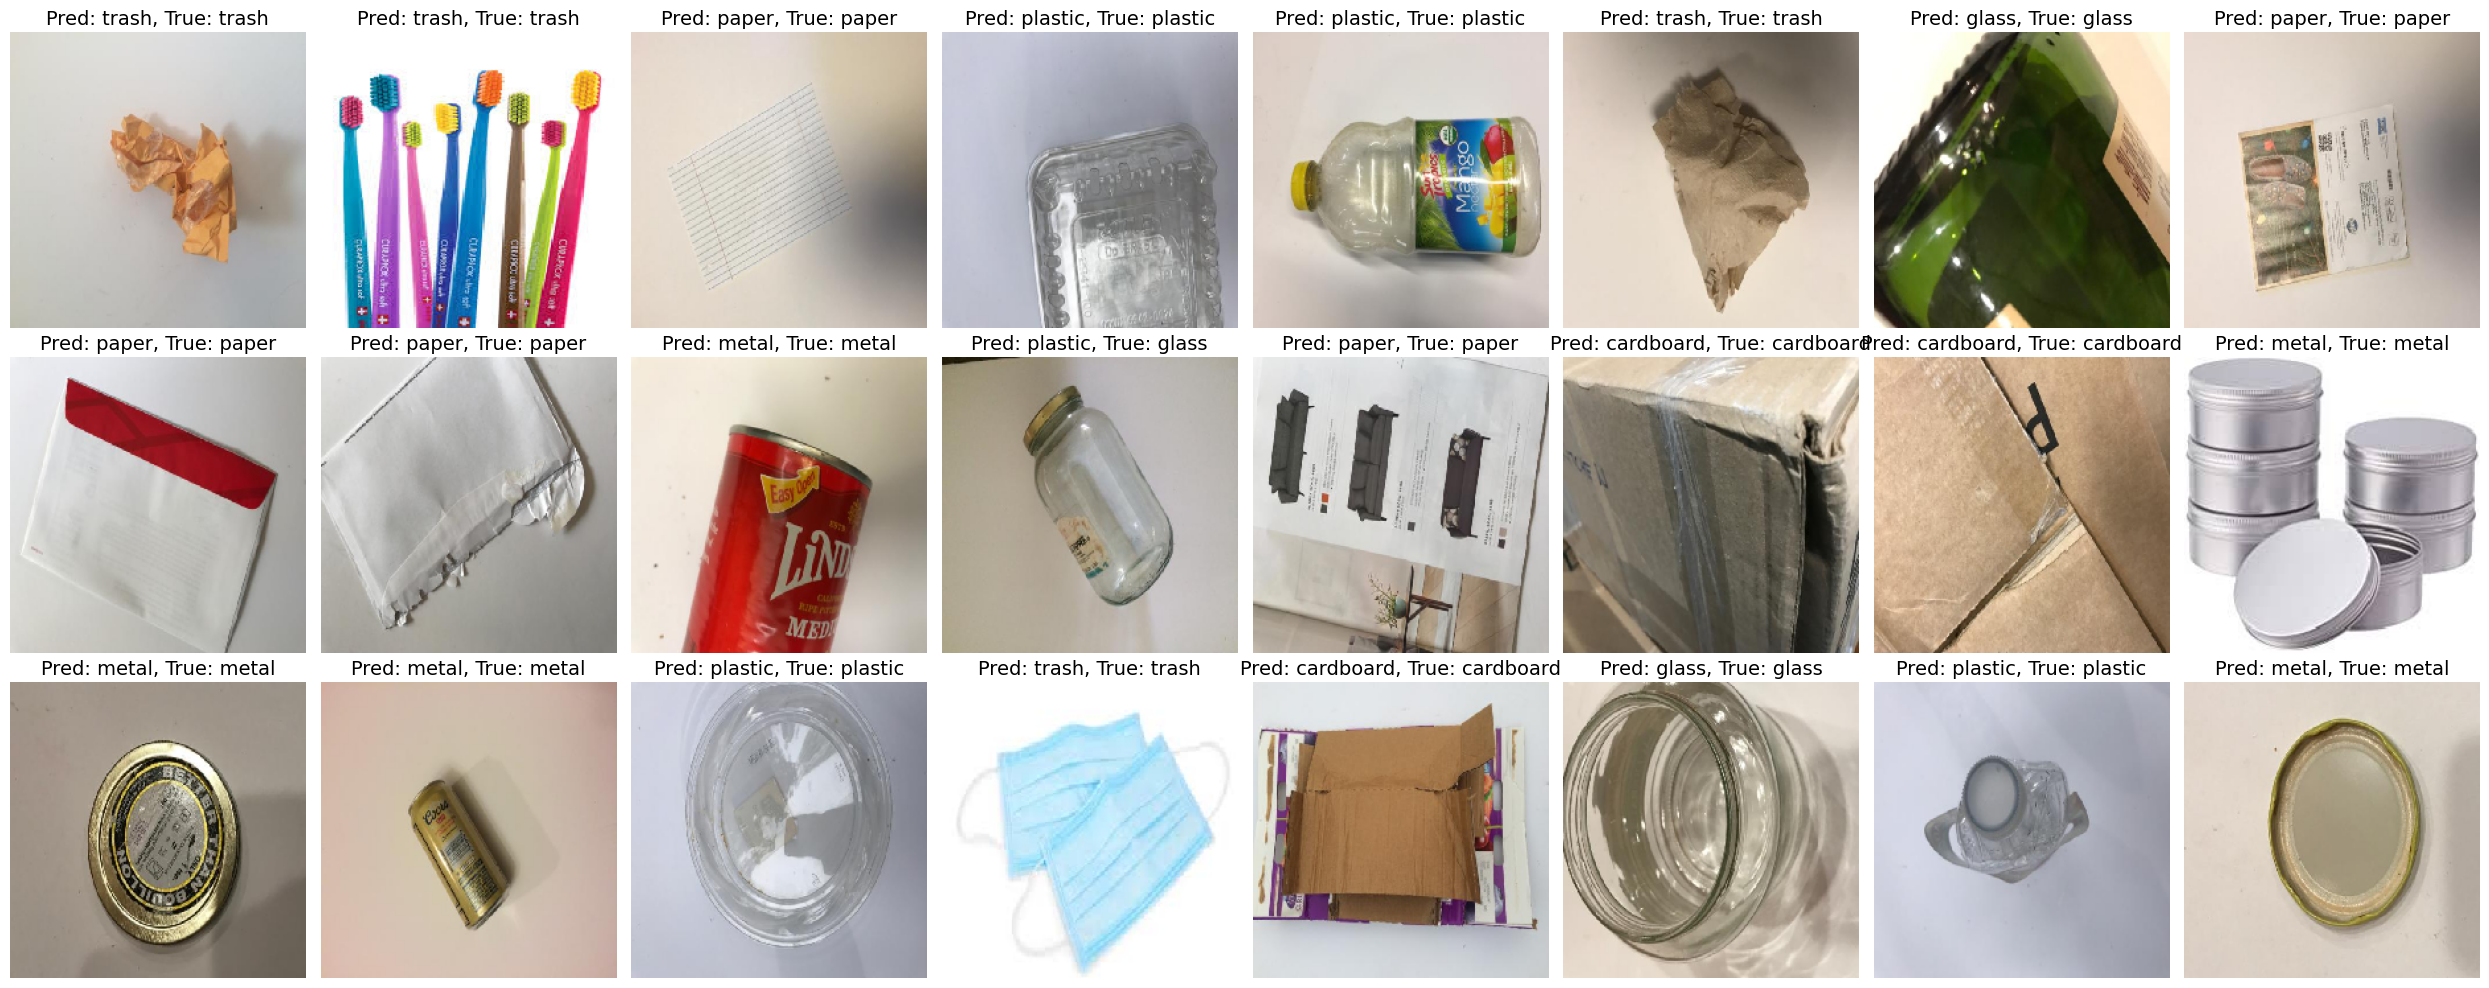

In [38]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [46]:
Model.save('waste_classification_mobilenetv2.h5')

In [48]:
Model.save_weights('waste_classification_mobilenetv2.weights.h5')

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model('waste_classification_model.h5')

# Load and preprocess a new image
img = image.load_img('path/to/new_waste_image.jpg', target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
predicted_class = class_names[np.argmax(prediction)]

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


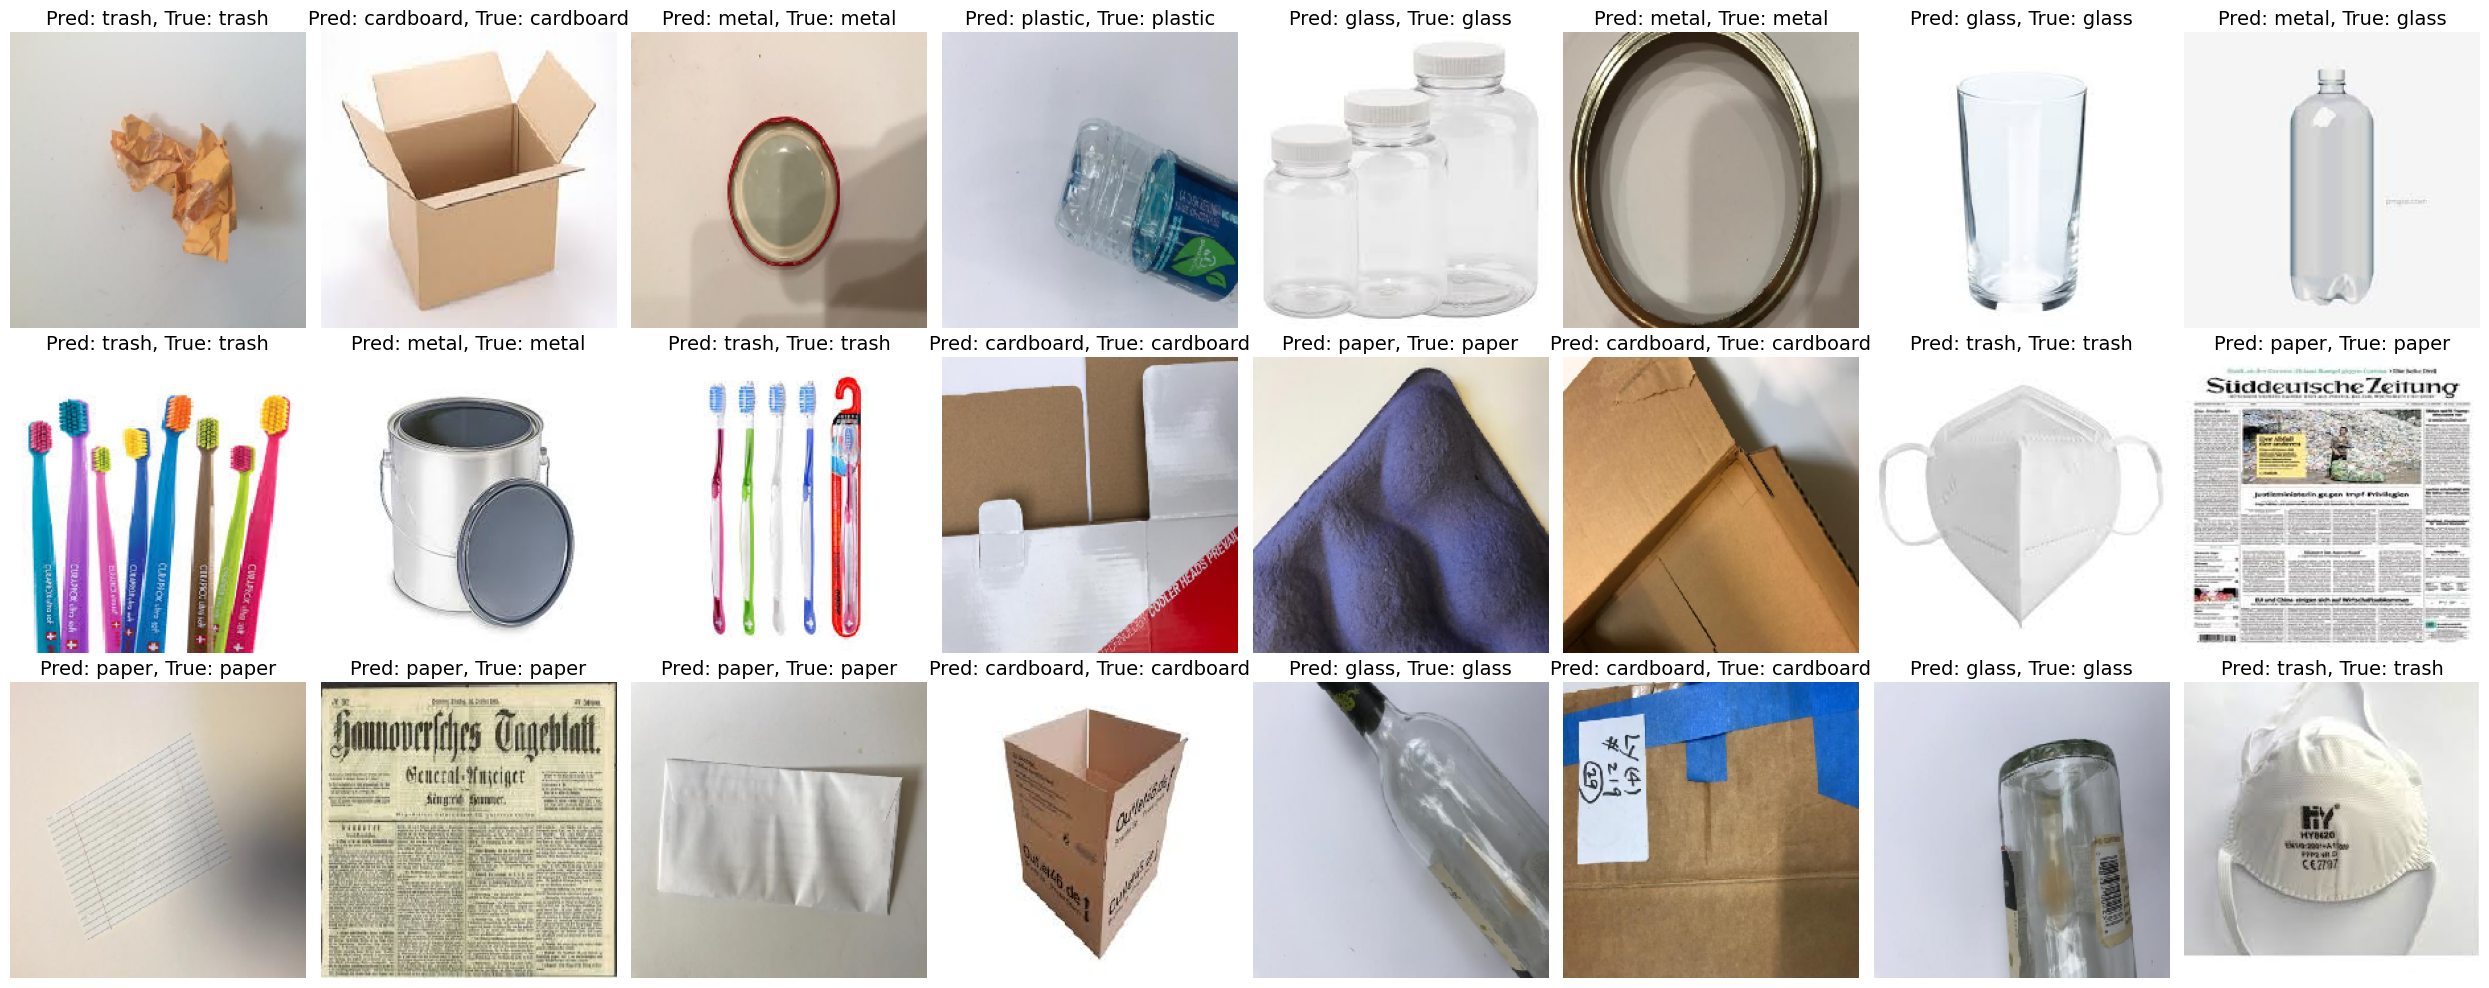

In [52]:
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model('waste_classification_mobilenetv2.h5')

# Define class names (from your training)
class_names = list(testGenerator.class_indices.keys())

# Use existing test generator
new_predictions = model.predict(testGenerator)
new_predicted_classes = [class_names[np.argmax(pred)] for pred in new_predictions]

# Get true classes
new_true_classes = [class_names[idx] for idx in testGenerator.classes]

# Get images for plotting (first 24)
testGenerator.reset()
images = []
for i in range(3):  # Get 3 batches to have enough images
    img_batch, _ = next(testGenerator)
    for img in img_batch:
        images.append(img)
        if len(images) >= 24:
            break
    if len(images) >= 24:
        break

# Your plotting code
fig, axs = plt.subplots(3, 8, figsize=(25, 10))
axs = axs.flatten()

for ax, img, pred, true in zip(axs, images[:24], new_predicted_classes[:24], new_true_classes[:24]):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}", fontsize=14)
    ax.axis('off')
    
plt.tight_layout()
plt.show()